### ***THỰC HÀNH TRANSFER LEARNING TRÊN TẬP pizza_steak_sushi***
Các file cần thiết đã được lưu (xem docs).  
Các module quan trọng trong file sẽ được viết thành file và chạy ở train.py

In [1]:
from pathlib import Path
import os 
data_path = Path('pizza_steak_sushi/')

In [2]:
from dataloader import dataprocess
datamodule = dataprocess.DataModule(data_dir=data_path, batch_size=32)

d:\Python\envs\DL_ENV\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [3]:
datamodule.setup()
train_loader, test_loader = datamodule.train_dataloader(), datamodule.test_dataloader()
class_names = datamodule.get_class_names()
train_loader,test_loader,class_names

(<torch.utils.data.dataloader.DataLoader at 0x272ae765840>,
 ['pizza', 'steak', 'sushi'])

In [4]:
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT chọn ra trọng số tốt nhất
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [5]:
import torch
from backbones import efficient_b0
device = torch.device('cuda:0')

In [6]:
import torchvision
datamodule = dataprocess.DataModule(data_dir = data_path, batch_size=16)
model = torchvision.models.efficientnet_b0()
transfer = efficient_b0.Transfered_Model(unfreeze_lr=0.0003)

In [7]:
from torchinfo import summary
transfer.unfreeze(num_trainable=3)
summary(transfer, [16, 3, 224, 224], col_names=['input_size','output_size','trainable'], row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Trainable
Transfered_Model (Transfered_Model)                          [16, 3, 224, 224]         [16, 3]                   Partial
├─Sequential (block_1)                                       [16, 3, 224, 224]         [16, 1280, 7, 7]          Partial
│    └─Conv2dNormActivation (0)                              [16, 3, 224, 224]         [16, 32, 112, 112]        False
│    │    └─Conv2d (0)                                       [16, 3, 224, 224]         [16, 32, 112, 112]        False
│    │    └─BatchNorm2d (1)                                  [16, 32, 112, 112]        [16, 32, 112, 112]        False
│    │    └─SiLU (2)                                         [16, 32, 112, 112]        [16, 32, 112, 112]        --
│    └─Sequential (1)                                        [16, 32, 112, 112]        [16, 16, 112, 112]        False
│    │    └─MBConv (0)                     

In [8]:
for i, param_group in enumerate(transfer.optimizer.param_groups):
    print(f"Group {i}: lr = {param_group['lr']}, num_params = {len(param_group['params'])}")


AttributeError: 'Transfered_Model' object has no attribute 'optimizer'

In [42]:
for params in model.features.parameters():
    params.requires_grad = False

In [43]:
summary(model, [32,3,224,224], col_names=['input_size', 'output_size', 'trainable'], row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape               Output Shape              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --
│    └─Sequential (1)                                        [32, 32, 112, 112]        [32, 16, 112, 112]        False
│    │    └─MBConv (0)                       

In [44]:

datamodule.setup()
# ví dụ:
X, y = next(iter(datamodule.test_dataloader()))
img = unnormalize(X[0]).permute(1,2,0)
plt.imshow(img)
plt.title(y[0].item())
plt.show()


KeyboardInterrupt: 

In [ ]:
X.shape

torch.Size([11, 3, 224, 224])

In [ ]:
best_model = efficient_b0.Transfered_Model.load_from_checkpoint(checkpoint_path=r'tb_log\lightning_logs\version_0\checkpoints\epoch=9-step=50.ckpt')


In [ ]:
%%writefile model_checker.py
'''
Hàm vẽ hình và so sánh dự đoán giữa pred và truth

Tham số:
bs: batch_size

Trả về:
3 hình ảnh và cặp truth, pred
'''
from backbones import efficient_b0 # đổi class này nếu dùng backbone khác

import numpy as np
import random
import matplotlib.pyplot as plt
from dataloader import dataprocess
import torch
from pathlib import Path
def pred_and_plot(base_model, bs = 32, checkpoint_path : str):
    def unnormalize(img):
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std[:, None, None] + mean[:, None, None]
        return img.clamp(0, 1)
        
    device = torch.device('cuda:0')

    datamodule = dataprocess.DataModule(bs)
    datamodule.setup(stage = 'test')
    test_loader = datamodule.test_dataloader()

    random_idx = np.random.randint(0,len(test_loader.dataset),3)
    best_model = efficient_b0.Transfered_Model.load_from_checkpoint(checkpoint_path=checkpoint_path).to(device)
    best_model.eval()
    with torch.inference_mode():
        for id in random_idx:
            plt.figure(figsize=(10,4))
            plt.imshow(unnormalize(test_loader.dataset[id][0]).permute(1,2,0))
            plt.axis(False)
            logits = best_model(test_loader.dataset[id][0].unsqueeze(0).to(device))
            pred = logits.argmax(1)
            plt.title([test_loader.dataset[id][1].item(), pred.item()])


Overwriting model_checker.py


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from dataloader import dataprocess # Giả sử import đúng
from backbones import efficient_b0 # Giả sử import đúng
import torch

def pred_and_plot(bs=32, num_samples=3): # Thêm num_samples
    '''
    Hàm vẽ hình và so sánh dự đoán giữa pred và truth

    Tham số:
    bs: batch_size dùng cho DataLoader
    num_samples: Số lượng ảnh muốn vẽ

    Trả về:
    num_samples hình ảnh và cặp truth, pred
    '''
    # --- 1. Xác định device ---
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # --- 2. Hàm unnormalize ---
    def unnormalize(img):
        # Giả sử đây là mean/std chuẩn của ImageNet hoặc khớp với lúc train
        mean = torch.tensor([0.485, 0.456, 0.406]).to(device) # Chuyển mean/std sang device
        std = torch.tensor([0.229, 0.224, 0.225]).to(device)
        img = img * std[:, None, None] + mean[:, None, None]
        return img.clamp(0, 1)

    # --- 3. Chuẩn bị DataLoader ---
    datamodule = dataprocess.DataModule(bs)
    datamodule.setup(stage='test') # Chỉ setup stage test
    test_loader = datamodule.test_dataloader()
    class_names = datamodule.get_class_names() # Lấy tên lớp

    # --- 4. Load Model ---
    # Nên truyền checkpoint_path như một tham số
    checkpoint_path = r'tb_log\lightning_logs\version_0\checkpoints\epoch=9-step=50.ckpt'
    try:
        best_model = efficient_b0.Transfered_Model.load_from_checkpoint(checkpoint_path=checkpoint_path)
        best_model.to(device) # Chuyển model sang device
        best_model.eval()
        print(f"Model loaded successfully from {checkpoint_path}")
    except FileNotFoundError:
        print(f"Error: Checkpoint file not found at {checkpoint_path}")
        return
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # --- 5. Lấy mẫu ngẫu nhiên và dự đoán ---
    images_to_plot = []
    labels_to_plot = []
    preds_to_plot = []

    # Lấy ngẫu nhiên num_samples từ test_loader mà không cần tải hết
    indices = random.sample(range(len(test_loader.dataset)), num_samples)
    for idx in indices:
        img, label = test_loader.dataset[idx] # Lấy trực tiếp từ dataset
        images_to_plot.append(img)
        labels_to_plot.append(label)

        # Dự đoán cho từng ảnh (thêm chiều batch)
        img_batch = img.unsqueeze(0).to(device) # Thêm chiều batch và chuyển sang device
        with torch.inference_mode():
            logits = best_model(img_batch)
            pred_label = logits.argmax(1).squeeze().item() # Lấy index dự đoán
            preds_to_plot.append(pred_label)

    # --- 6. Vẽ hình ---
    plt.figure(figsize=(10, num_samples * 3.5)) # Điều chỉnh figsize
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i+1)
        # Chuyển ảnh về CPU để unnormalize và plot nếu cần
        img_display = unnormalize(images_to_plot[i].to(device)).cpu()
        plt.imshow(img_display.permute(1, 2, 0))
        plt.axis(False)
        true_label_name = class_names[labels_to_plot[i]]
        pred_label_name = class_names[preds_to_plot[i]]
        title_color = 'g' if true_label_name == pred_label_name else 'r'
        plt.title(f"Truth: {true_label_name} | Pred: {pred_label_name}", color=title_color)
    plt.tight_layout() # Giúp các subplot không bị chồng chéo
    plt.show()

# Gọi hàm để chạy
# pred_and_plot(bs=32, num_samples=3)

In [ ]:
from torchmetrics import F1Score,ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
def show_confusion_matrix(model, datamodule):
    device = torch.device('cuda:0')
    datamodule.setup(stage = 'test')
    test_loader = datamodule.test_dataloader()
    predictions = []
    model.eval()
    with torch.inference_mode():
        for X,_ in test_loader:
            logits = model(X.to(device))
            predictions.append(logits.argmax(1).to('cpu'))
        predictions = torch.concat(predictions)
    confmat = ConfusionMatrix(task = 'multiclass', num_classes=len(datamodule.get_class_names()))
    confmat_data = confmat(predictions, torch.Tensor(test_loader.dataset.targets))
    fig, ax = plot_confusion_matrix(conf_mat=confmat_data.numpy(),
                                    class_names=datamodule.get_class_names(),
                                    figsize=(10,5))

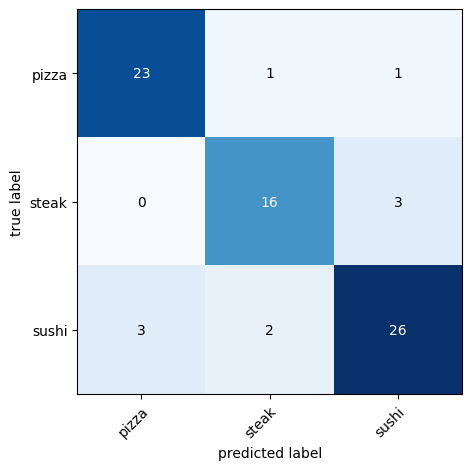

In [ ]:
show_confusion_matrix(best_model, datamodule)